#### Can KMeans Clustering Help Identify Style Factors?

Factor investing looks at the underlying, persistent "factors" that drive investing returns. These "factors" have been studied over long periods of time and prove - over and over again - to be rules of return.

An example factor is the "size style factor." Here, the persistent rule is that smaller, more nimble companies tend to outperform larger companies. Smaller companies pose higher risk as they have typically less established, less liquid, and more susceptible to market movements. 

In this quick experiment, we see if KMeans can help cluster different companies by their factor tilts. 

In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
import pandas as pd
import pprint
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

#### Data sources

We are drawing from two data sources. The first is a list of fundamental data on tickers within the NYSE. The second is a dataset of closing stock prices of the same companies.

In [2]:
# Create dataframe and examine column names

fundamentals = pd.read_csv("./data/nyse/fundamentals.csv")

prices = pd.read_csv("./data/nyse/prices-split-adjusted.csv")

#### Variables of interesting

We plot each ticker by their **gross margin percentage** and the **percent change in stock price** over the calendar year 2016. Typically, companies that exhibit both high gross margin and positive price changes are classified as "Quality-Momentum" multifactor stocks. Below is a definition of both factors from BlackRock's Andrew Ang:

**Momentum.** The intuition of momentum is simple: prices moving upward tend to continue moving in that direction. Momentum may perform best during expansion mode, when growth is accelerating and trends persist.

**Quality.** The intuition is that financially healthy companies tend to outperform less-efficient peers. Quality has worked due to investor bias: superficial investors are attracted by high headline earnings, while diligent contrarians investigate the underling composition.

#### How can clustering can help?

KMeans clustering can **help identify the different groups of "Quality-Momentum" multi-factor stocks in a less-biased manner.** Investors often draw their own arbitrary lines about what counts and what doesn't. KMeans can do the heavy lifting for us.

In [3]:
# Pull gross margin, stock ticker, and period from fundamentals dataframe

margin_data = pd.DataFrame({'period_end': fundamentals['Period Ending'], 'symbol': fundamentals['Ticker Symbol'], 'gross' : fundamentals['Gross Margin']})
margin_data = margin_data.sort_values(by=['symbol', 'period_end'])
margin_data = margin_data[~margin_data.symbol.duplicated(keep='last')]

# Preview data

margin_data.head()

,gross,period_end,symbol
3,73.0,2015-12-31,AAL
7,45.0,2016-01-02,AAP
11,39.0,2016-09-24,AAPL
15,80.0,2015-12-31,ABBV
19,3.0,2016-09-30,ABC


In [4]:
# Reduce percentages

margin_data['gross'] = margin_data['gross'].apply(lambda x: x/100)

margin_data.head()

,gross,period_end,symbol
3,0.73,2015-12-31,AAL
7,0.45,2016-01-02,AAP
11,0.39,2016-09-24,AAPL
15,0.80,2015-12-31,ABBV
19,0.03,2016-09-30,ABC


In [5]:
# Create dataframe of closing prices

price_data = pd.DataFrame({'date': prices['date'], 'symbol': prices['symbol'], 'close': prices['close']})
price_data = price_data[(price_data['date'] == '2016-01-04') | (price_data['date'] == '2016-12-30')]
price_data = price_data.sort_values(by=['symbol', 'date'])

price_data.head()

,close,date,symbol
725390,40.689999,2016-01-04,A
850764,45.560001,2016-12-30,A
725391,40.910000,2016-01-04,AAL
850765,46.689999,2016-12-30,AAL
725392,152.240005,2016-01-04,AAP


In [10]:
# Rearrange data 

price_data['dateTime'] = pd.to_datetime(price_data.date, infer_datetime_format= True)

symMaxDate = price_data.groupby(['symbol'])['dateTime'].max()

symMaxDate = pd.DataFrame({'symbol':symMaxDate.index, 'dateTime':symMaxDate.values})

symMaxDate = symMaxDate.merge(price_data, on='symbol', how='inner',suffixes=["","_max"])

symMaxDate = symMaxDate[symMaxDate.dateTime == symMaxDate.dateTime_max]

In [11]:
# Calculate percentage change for calendar year 2016

price_data = price_data.merge(symMaxDate[['symbol','close','dateTime_max']], on="symbol", how = "outer", suffixes = ['','_max'])
price_data['perc_change'] = (price_data.close_max - price_data.close)/price_data.close
change_2016 = price_data[price_data.date == "2016-01-04"][['symbol',"perc_change"]]
change_2016.head()

,symbol,perc_change
0,A,0.119685
2,AAL,0.141286
4,AAP,0.110877
6,AAPL,0.099383
8,ABBV,0.086964


In [12]:
# Merge data into one array

gross_v_change = pd.merge(change_2016, margin_data, on='symbol', how='inner')

gross_v_change.head(10)

,symbol,perc_change,gross,period_end
0,AAL,0.141286,0.73,2015-12-31
1,AAP,0.110877,0.45,2016-01-02
2,AAPL,0.099383,0.39,2016-09-24
3,ABBV,0.086964,0.80,2015-12-31
4,ABC,-0.232453,0.03,2016-09-30
5,ABT,-0.105288,0.57,2015-12-31
6,ADBE,0.119387,0.86,2016-12-02
7,ADI,0.333946,0.65,2016-10-29
8,ADM,0.273717,0.06,2015-12-31
9,ADS,-0.159030,0.30,2015-12-31


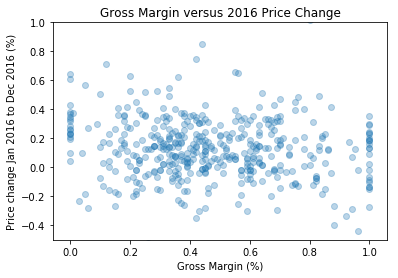

In [13]:
# Plot gross margin versus 2016 price change (%)

plt.scatter(x = gross_v_change.gross, y = gross_v_change.perc_change, alpha = 0.3)
plt.ylim([-0.5,1.0])
plt.xlabel("Gross Margin (%)")
plt.ylabel("Price change Jan 2016 to Dec 2016 (%)")
plt.title("Gross Margin versus 2016 Price Change")

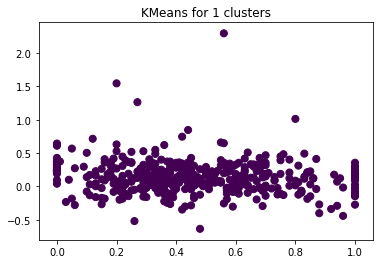

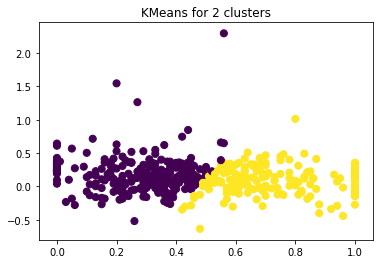

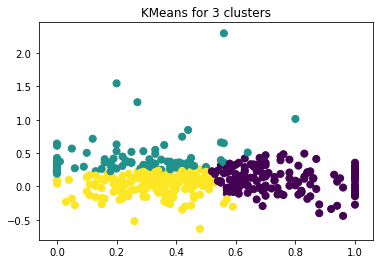

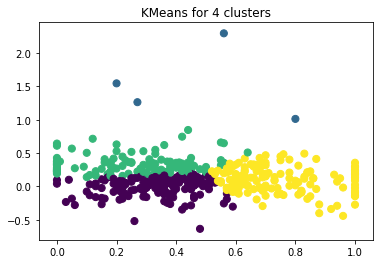

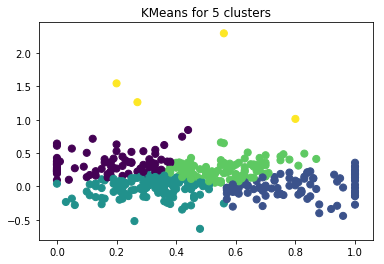

In [15]:
# Create one array

X = gross_v_change[['gross', 'perc_change']].values

# Fit KMeans for k in [1,5] to see potential clusters

for k in range(1,6):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)
    plt.title("KMeans for {n} clusters".format(n=str(k)))
    plt.show()

#### Discussion

In reality, it's very hard to find clean, distinct clusters in financial data. Groups of 1 or 2 stocks may seem like outliers but, it's those uncorrelated few that can give a portfolio manager an edge. 

The KMeans where n_components = 5 provided the most satisfying clusters. First, it divided the data set by positive and negative growth rate. Second, it grouped the 4 stocks with unusually high price increases. Third, it segmented the clusters by high, medium, and low gross margins. 

Investors bring their own biases to categorization. For example, the standard McKinsey style 2 X 2 arbitrarily groups data into quandrants. KMeans could be an interesting alternatively to human-determined factor defnitions. 